Vehicle dataset

--> em rupias indianas

Kaggle Link: https://www.kaggle.com/datasets/nehalbirla/vehicle-dataset-from-cardekho?select=Car+details+v3.csv

In [1]:
import pandas as pd
import plotly.express as px
import numpy as np
import cut_the_tails as ct
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from xgboost import XGBClassifier, XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import make_column_transformer

In [2]:
df = pd.read_csv('data_sets\\Car_details.csv')
target = 'selling_price'

In [3]:
features = [
 'year',
 'selling_price',
 'km_driven',
 'seats',
 'fuel',
 'seller_type',
 'transmission',
 'owner',
 'mileage',
 'engine',
 'max_power'
 ]

In [4]:
fig = px.histogram(df, x=target, nbins=200)
fig.show()

# Pré-Processamento 

In [5]:
df.drop('torque', axis=1, inplace=True)
df.drop('name', axis=1, inplace=True)
#the columns that have nominal attributes
nominal_atts = ['fuel', 'seller_type', 'transmission', 'owner']

#removing the units of measurements from the dataframe
df['mileage'] = df['mileage'].str.replace(' kmpl', '')
df['mileage'] = df['mileage'].str.replace(' km/kg', '')
df = df[df.mileage !='']
df['engine'] = df['engine'].str.replace(' CC', '')
df = df[df.engine !='']
df['max_power'] = df['max_power'].str.replace(' bhp', '')
df = df[df.max_power !='']

#using the one hot encoder
one = OneHotEncoder()

transformer = make_column_transformer((OneHotEncoder(sparse_output=False), nominal_atts), remainder='passthrough')

transformed = transformer.fit_transform(df)

transformed_df = pd.DataFrame(transformed, columns=transformer.get_feature_names_out())

# Updating the features list
features = transformer.get_feature_names_out().tolist()
target = 'remainder__selling_price'
features.remove(target)

transformed_df.head()


,onehotencoder__fuel_CNG,onehotencoder__fuel_Diesel,onehotencoder__fuel_LPG,onehotencoder__fuel_Petrol,onehotencoder__seller_type_Dealer,onehotencoder__seller_type_Individual,onehotencoder__seller_type_Trustmark Dealer,onehotencoder__transmission_Automatic,onehotencoder__transmission_Manual,onehotencoder__owner_First Owner,...,onehotencoder__owner_Second Owner,onehotencoder__owner_Test Drive Car,onehotencoder__owner_Third Owner,remainder__year,remainder__selling_price,remainder__km_driven,remainder__mileage,remainder__engine,remainder__max_power,remainder__seats
0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,...,0.0,0.0,0.0,2014,450000,145500,23.4,1248,74,5.0
1,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,...,1.0,0.0,0.0,2014,370000,120000,21.14,1498,103.52,5.0
2,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,...,0.0,0.0,1.0,2006,158000,140000,17.7,1497,78,5.0
3,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,...,0.0,0.0,0.0,2010,225000,127000,23.0,1396,90,5.0
4,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,...,0.0,0.0,0.0,2007,130000,120000,16.1,1298,88.2,5.0


# Cauda Ótima

ValueError: Input X contains NaN.
DecisionTreeClassifier does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values

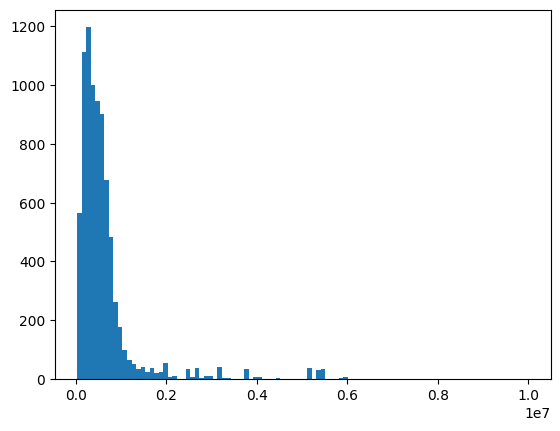

In [6]:
df.dropna(inplace=True)
df = df.reset_index(drop=True)

model = DecisionTreeRegressor(random_state=0, max_depth=5) 
classifier = DecisionTreeClassifier(random_state=0, max_depth=5)

optimal = ct.get_optimal_percentiles(transformed_df, target, features, classifier, model, 'normal', 'brute-force', 1)

print(optimal)

In [15]:
cdf = ct.split_by_quantile_class(transformed_df,target,[0.025,0.20])

cdf.dropna(inplace=True)

In [16]:
X = cdf[features].to_numpy()
y_tail = cdf['tail_class'].to_numpy()
y = cdf[target].to_numpy()

###Using split###
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
X_train_aux, X_test_aux, y_train_tail, y_test_tail = train_test_split(X, y_tail, test_size=0.2, random_state=0)

In [17]:
baseline = RandomForestRegressor(max_depth=5, random_state=0)
#baseline = XGBRegressor(n_estimators=100, max_leaves=0, random_state = 0)
#baseline = DecisionTreeRegressor(random_state=0, max_depth=5) 

In [18]:
#tail_classifier = ct.fit_tail_classifier(X,y_tail,RandomForestClassifier(max_depth=5, random_state=0))
#tail_classifier = ct.fit_tail_classifier(X,y_tail,XGBClassifier(n_estimators=100, max_leaves=0, random_state = 0))
#tail_classifier = ct.fit_tail_classifier(X,y_tail,DecisionTreeClassifier(random_state=0, max_depth=5)) 

###Using split###
tail_classifier = ct.fit_tail_classifier(X_train,y_train_tail,RandomForestClassifier(max_depth=5, random_state=0))
#tail_classifier = ct.fit_tail_classifier(X_train,y_train_tail,XGBClassifier(n_estimators=100, max_leaves=0, random_state = 0))
#tail_classifier = ct.fit_tail_classifier(X_train,y_train_tail,DecisionTreeClassifier(random_state=0, max_depth=5)) 

In [19]:
#models = ct.fit_tail_models(X,y,y_tail,baseline)

###Using split###
models = ct.fit_tail_models(X_train,y_train,y_train_tail,baseline)

In [20]:
#baseline.fit(X,y)
#y_base = baseline.predict(X)
#y_tail = ct.batch_tail_predict(X,tail_classifier,models)

###Using split###
baseline.fit(X_train,y_train)
y_base = baseline.predict(X_test)
y_tail = ct.batch_tail_predict(X_test,tail_classifier,models)

In [21]:
#print(mean_absolute_error(y_base,y))
#print(mean_absolute_error(y_tail,y))
#print(mean_absolute_error(y,y))

###Using split###
print(mean_absolute_error(y_base,y_test))
print(mean_absolute_error(y_tail,y_test))
print(mean_absolute_error(y_test,y_test))

118462.09537797616
121430.14317637388
0.0


In [22]:
#print(mean_absolute_percentage_error(y_base,y))
#print(mean_absolute_percentage_error(y_tail,y))
#print(mean_absolute_percentage_error(y,y))

###Using split###
print(mean_absolute_percentage_error(y_base,y_test))
print(mean_absolute_percentage_error(y_tail,y_test))
print(mean_absolute_percentage_error(y_test,y_test))

0.229943826815772
0.22629609702310677
0.0
